#### 소득 부채 비율

In [ ]:
import pandas as pd


df_wealth = pd.read_csv('/content/drive/MyDrive/25-1 DSL/EDA/계층 분석/소득분위별_자산__부채__순자산_점유율.csv', encoding='cp949', skiprows=1)


df_wealth.columns = ['소득분위', '자산항목', '2017', '2018', '2019']
df_wealth = df_wealth[['소득분위', '자산항목', '2018']]

df_wealth = df_wealth[df_wealth['2018'].astype(str).str.contains('보유액') == False]


df_wealth['2018'] = df_wealth['2018'].astype(str).str.replace(',', '').astype(float)


df_wealth_pivot = df_wealth.pivot(index='소득분위', columns='자산항목', values='2018').reset_index()
df_wealth_pivot.columns.name = None
df_wealth_pivot.columns = ['소득분위', '부채', '순자산', '자산']


display(df_wealth_pivot)


,소득분위,부채,순자산,자산
0,소득 1분위,1610.0,11871.0,13482.0
1,소득 2분위,3868.0,19850.0,23718.0
2,소득 3분위,6581.0,28151.0,34731.0
3,소득 4분위,9130.0,37697.0,46827.0
4,소득 5분위,17150.0,74264.0,91414.0
5,전체,7668.0,34368.0,42036.0


가구특성별 소득구간별 자료 전처리
- 소득 구간을 통일하기 위해 5가지로 컬럼 축소

(1) 1000만 미만 구간과 1000~3000 미만 통합하는 경우

In [ ]:
import pandas as pd

# -----------------------------
# 소득분위 자산/부채 데이터 로딩 및 정리
# -----------------------------
df_wealth = pd.read_csv('/content/drive/MyDrive/25-1 DSL/EDA/계층 분석/소득분위별_자산__부채__순자산_점유율.csv', encoding='cp949', skiprows=1)
df_wealth.columns = ['소득분위', '자산항목', '2017', '2018', '2019']
df_wealth = df_wealth[['소득분위', '자산항목', '2018']]
df_wealth = df_wealth[~df_wealth['2018'].astype(str).str.contains('보유액', na=False)]
df_wealth['2018'] = df_wealth['2018'].astype(str).str.replace(',', '').astype(float)

# 피벗
df_wealth_pivot = df_wealth.pivot(index='소득분위', columns='자산항목', values='2018').reset_index()
df_wealth_pivot.columns.name = None
df_wealth_pivot.columns = ['소득분위', '부채', '순자산', '자산']


df_wealth_pivot['소득분위'] = (
    df_wealth_pivot['소득분위'].astype(str).str.extract(r'(\d+)')[0]
)
df_wealth_pivot = df_wealth_pivot.dropna(subset=['소득분위'])
df_wealth_pivot['소득분위'] = df_wealth_pivot['소득분위'].astype(int)


df_wealth_pivot = df_wealth_pivot[df_wealth_pivot['소득분위'].between(1, 5)]


분위_to_소득구간 = {
    1: '3,000만원 미만',
    2: '3,000~5,000만원 미만',
    3: '5,000~7,000만원 미만',
    4: '7,000~9,000만원 미만',
    5: '9,000만원 이상'
}
df_wealth_pivot['소득구간'] = df_wealth_pivot['소득분위'].map(분위_to_소득구간)

# -----------------------------
# 가구 비중 데이터 정리 및 시나리오 적용 (하위 2개 통합)
# -----------------------------
df_household = pd.read_csv('/content/drive/MyDrive/25-1 DSL/EDA/계층 분석/가구특성별_소득구간별_가구분포.csv', encoding='cp949')
df_household.columns = ['가구특성별', '소득구간', '2017', '2018', '2019']

df_long = df_household.melt(
    id_vars=['가구특성별', '소득구간'],
    var_name='시점',
    value_name='가구비중'
)
df_filtered = df_long[
    (df_long['시점'] == '2018') & (df_long['가구특성별'] == '전체')
][['소득구간', '가구비중']].reset_index(drop=True)
df_filtered['가구비중'] = df_filtered['가구비중'].astype(str).str.replace(',', '').astype(float)

# 시나리오1 매핑: 하위 두 구간 통합
scenario1_mapping = {
    '1,000만원 미만': '3,000만원 미만',
    '1,000~3,000만원 미만': '3,000만원 미만',
    '3,000~5,000만원 미만': '3,000~5,000만원 미만',
    '5,000~7,000만원 미만': '5,000~7,000만원 미만',
    '7,000~10,000만원 미만': '7,000~9,000만원 미만',
    '10,000만원 이상': '9,000만원 이상'
}
df_filtered['소득구간'] = df_filtered['소득구간'].map(scenario1_mapping)
df_scenario1 = df_filtered.groupby('소득구간', as_index=False)['가구비중'].sum()

# -----------------------------
# 병합 및 실질 타격 강도 계산
# -----------------------------
df_merged = pd.merge(df_wealth_pivot, df_scenario1, on='소득구간', how='inner')
df_merged['대출의존도'] = df_merged['부채'] / df_merged['자산']
df_merged['실질타격강도'] = df_merged['대출의존도'] * df_merged['가구비중']


df_result = df_merged[['소득구간', '자산', '부채', '대출의존도', '가구비중', '실질타격강도']].sort_values('실질타격강도', ascending=False)
display(df_result)


,소득구간,자산,부채,대출의존도,가구비중,실질타격강도
0,"3,000만원 미만",13482.0,1610.0,0.119418,33.4,3.988577
1,"3,000~5,000만원 미만",23718.0,3868.0,0.163083,22.0,3.587824
2,"5,000~7,000만원 미만",34731.0,6581.0,0.189485,15.9,3.012810
3,"7,000~9,000만원 미만",46827.0,9130.0,0.194973,14.7,2.866103
4,"9,000만원 이상",91414.0,17150.0,0.187608,14.0,2.626512


(2) 7000~10000 미만과 10000 이상을 통합하는 경우

타격강도

#### 연도별 타격 강도 비교

In [ ]:
import pandas as pd

# -----------------------------
소득 분위 → 소득구간 매핑
# -----------------------------
분위_to_소득구간 = {
    1: '3,000만원 미만',
    2: '3,000~5,000만원 미만',
    3: '5,000~7,000만원 미만',
    4: '7,000~9,000만원 미만',
    5: '9,000만원 이상'
}

소득구간_매핑 = {
    '1,000만원 미만': '3,000만원 미만',
    '1,000~3,000만원 미만': '3,000만원 미만',
    '3,000~5,000만원 미만': '3,000~5,000만원 미만',
    '5,000~7,000만원 미만': '5,000~7,000만원 미만',
    '7,000~10,000만원 미만': '7,000~9,000만원 미만',
    '10,000만원 이상': '9,000만원 이상'
}

# -----------------------------
# 함수: 연도별 실질타격강도 계산
# -----------------------------
def analyze_year(year):
    print(f"\n📊 {year}년 결과 ------------------")


    df_wealth = pd.read_csv('/content/drive/MyDrive/25-1 DSL/EDA/계층 분석/소득분위별_자산__부채__순자산_점유율.csv', encoding='cp949', skiprows=1)
    df_wealth.columns = ['소득분위', '자산항목', '2017', '2018', '2019']
    df_wealth = df_wealth[['소득분위', '자산항목', str(year)]]
    df_wealth = df_wealth[~df_wealth[str(year)].astype(str).str.contains('보유액', na=False)]
    df_wealth[str(year)] = df_wealth[str(year)].astype(str).str.replace(',', '').astype(float)

    df_wealth_pivot = df_wealth.pivot(index='소득분위', columns='자산항목', values=str(year)).reset_index()
    df_wealth_pivot.columns.name = None
    df_wealth_pivot.columns = ['소득분위', '부채', '순자산', '자산']


    df_wealth_pivot['소득분위'] = df_wealth_pivot['소득분위'].astype(str).str.extract(r'(\d+)')[0]
    df_wealth_pivot = df_wealth_pivot.dropna(subset=['소득분위'])
    df_wealth_pivot['소득분위'] = df_wealth_pivot['소득분위'].astype(int)
    df_wealth_pivot = df_wealth_pivot[df_wealth_pivot['소득분위'].between(1, 5)]
    df_wealth_pivot['소득구간'] = df_wealth_pivot['소득분위'].map(분위_to_소득구간)


    df_household = pd.read_csv('/content/drive/MyDrive/25-1 DSL/EDA/계층 분석/가구특성별_소득구간별_가구분포.csv', encoding='cp949')
    df_household.columns = ['가구특성별', '소득구간', '2017', '2018', '2019']

    df_long = df_household.melt(
        id_vars=['가구특성별', '소득구간'],
        var_name='시점',
        value_name='가구비중'
    )
    df_filtered = df_long[
        (df_long['시점'] == str(year)) & (df_long['가구특성별'] == '전체')
    ][['소득구간', '가구비중']].reset_index(drop=True)
    df_filtered['가구비중'] = df_filtered['가구비중'].astype(str).str.replace(',', '').astype(float)

    df_filtered['소득구간'] = df_filtered['소득구간'].map(소득구간_매핑)
    df_scenario = df_filtered.groupby('소득구간', as_index=False)['가구비중'].sum()

    df_merged = pd.merge(df_wealth_pivot, df_scenario, on='소득구간', how='inner')
    df_merged['대출의존도'] = df_merged['부채'] / df_merged['자산']
    df_merged['실질타격강도'] = df_merged['대출의존도'] * df_merged['가구비중']


    df_result = df_merged[['소득구간', '자산', '부채', '대출의존도', '가구비중', '실질타격강도']].sort_values('실질타격강도', ascending=False)
    display(df_result)


analyze_year(2017)
analyze_year(2018)
analyze_year(2019)



📊 2017년 결과 ------------------


,소득구간,자산,부채,대출의존도,가구비중,실질타격강도
0,"3,000만원 미만",12444.0,1514.0,0.121665,34.7,4.221778
1,"3,000~5,000만원 미만",21930.0,3670.0,0.167351,22.0,3.681715
2,"5,000~7,000만원 미만",31792.0,6155.0,0.193602,16.3,3.155715
3,"7,000~9,000만원 미만",44153.0,8678.0,0.196544,14.2,2.790922
4,"9,000만원 이상",83023.0,15475.0,0.186394,12.8,2.385845



📊 2018년 결과 ------------------


,소득구간,자산,부채,대출의존도,가구비중,실질타격강도
0,"3,000만원 미만",13482.0,1610.0,0.119418,33.4,3.988577
1,"3,000~5,000만원 미만",23718.0,3868.0,0.163083,22.0,3.587824
2,"5,000~7,000만원 미만",34731.0,6581.0,0.189485,15.9,3.012810
3,"7,000~9,000만원 미만",46827.0,9130.0,0.194973,14.7,2.866103
4,"9,000만원 이상",91414.0,17150.0,0.187608,14.0,2.626512



📊 2019년 결과 ------------------


,소득구간,자산,부채,대출의존도,가구비중,실질타격강도
0,"3,000만원 미만",13078.0,1628.0,0.124484,32.6,4.058174
1,"3,000~5,000만원 미만",23948.0,3728.0,0.155671,21.3,3.315784
2,"5,000~7,000만원 미만",35273.0,6617.0,0.187594,16.5,3.095300
3,"7,000~9,000만원 미만",49027.0,9886.0,0.201644,14.5,2.923838
4,"9,000만원 이상",94608.0,17687.0,0.186950,15.0,2.804255


가구 비중 평균처리

In [ ]:
import pandas as pd


df_wealth = pd.read_csv('/content/drive/MyDrive/25-1 DSL/EDA/계층 분석/소득분위별_자산__부채__순자산_점유율.csv', encoding='cp949', skiprows=1)
df_wealth.columns = ['소득분위', '자산항목', '2017', '2018', '2019']
df_wealth = df_wealth[['소득분위', '자산항목', '2018']]
df_wealth = df_wealth[df_wealth['2018'].astype(str).str.contains('보유액') == False]
df_wealth['2018'] = df_wealth['2018'].astype(str).str.replace(',', '').astype(float)
df_wealth_pivot = df_wealth.pivot(index='소득분위', columns='자산항목', values='2018').reset_index()
df_wealth_pivot.columns.name = None
df_wealth_pivot.columns = ['소득분위', '부채', '순자산', '자산']


df_wealth_pivot['소득분위'] = df_wealth_pivot['소득분위'].astype(str).str.extract(r'(\d+)')[0].astype(float)


분위_to_신소득구간 = {
    1: '2000만원 미만',
    2: '2,000~4,000만원 미만',
    3: '4,000~6,000만원 미만',
    4: '6,000~8,000만원 미만',
    5: '8,000만원 이상'
}
df_wealth_pivot = df_wealth_pivot[df_wealth_pivot['소득분위'] <= 5]
df_wealth_pivot['소득구간'] = df_wealth_pivot['소득분위'].map(분위_to_신소득구간)


df_grouped = df_wealth_pivot.groupby('소득구간', as_index=False)[['자산', '부채']].mean()


가구비중_2018 = {
    '2000만원 미만': 13.8,
    '2,000~4,000만원 미만': 27.9,
    '4,000~6,000만원 미만': 23,
    '6,000~8,000만원 미만': 19.3,
    '8,000만원 이상': 16
}
df_grouped['가구비중'] = df_grouped['소득구간'].map(가구비중_2018)


df_grouped['대출의존도'] = df_grouped['부채'] / df_grouped['자산']
df_grouped['실질타격강도'] = df_grouped['대출의존도'] * df_grouped['가구비중']


df_result = df_grouped[['소득구간', '자산', '부채', '가구비중', '대출의존도', '실질타격강도']]
df_result = df_result.sort_values('실질타격강도', ascending=False).reset_index(drop=True)
display(df_result)


,소득구간,자산,부채,가구비중,대출의존도,실질타격강도
0,"2,000~4,000만원 미만",23718.0,3868.0,27.9,0.163083,4.550013
1,"4,000~6,000만원 미만",34731.0,6581.0,23.0,0.189485,4.358153
2,"6,000~8,000만원 미만",46827.0,9130.0,19.3,0.194973,3.762979
3,"8,000만원 이상",91414.0,17150.0,16.0,0.187608,3.001728
4,2000만원 미만,13482.0,1610.0,13.8,0.119418,1.647975


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

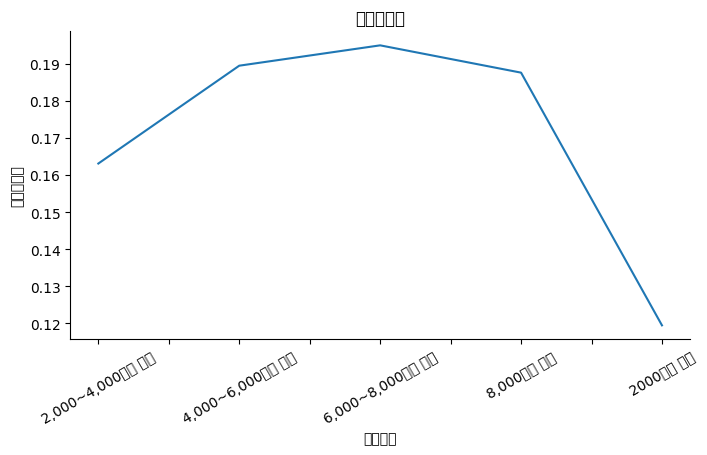

In [ ]:
df_result.set_index('소득구간')['대출의존도'].plot(kind='line', figsize=(8, 4), title='대출의존도')
plt.xlabel('소득구간')
plt.ylabel('대출의존도')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xticks(rotation=30)
plt.show()

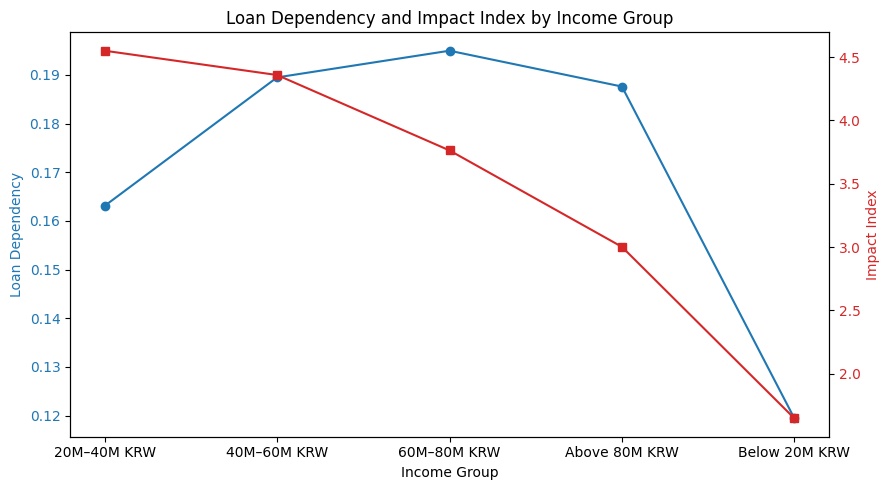

In [ ]:
import matplotlib.pyplot as plt

eng_labels = {
    '2000만원 미만': 'Below 20M KRW',
    '2,000~4,000만원 미만': '20M–40M KRW',
    '4,000~6,000만원 미만': '40M–60M KRW',
    '6,000~8,000만원 미만': '60M–80M KRW',
    '8,000만원 이상': 'Above 80M KRW'
}

df_plot = df_result.copy()
df_plot['Income Group'] = df_plot['소득구간'].map(eng_labels)

fig, ax1 = plt.subplots(figsize=(9, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Income Group')
ax1.set_ylabel('Loan Dependency', color=color1)
ax1.plot(df_plot['Income Group'], df_plot['대출의존도'],
         color=color1, marker='o', label='Loan Dependency')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Impact Index', color=color2)
ax2.plot(df_plot['Income Group'], df_plot['실질타격강도'],
         color=color2, marker='s', label='Impact Index')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Loan Dependency and Impact Index by Income Group')
plt.xticks(rotation=30)
fig.tight_layout()
plt.show()


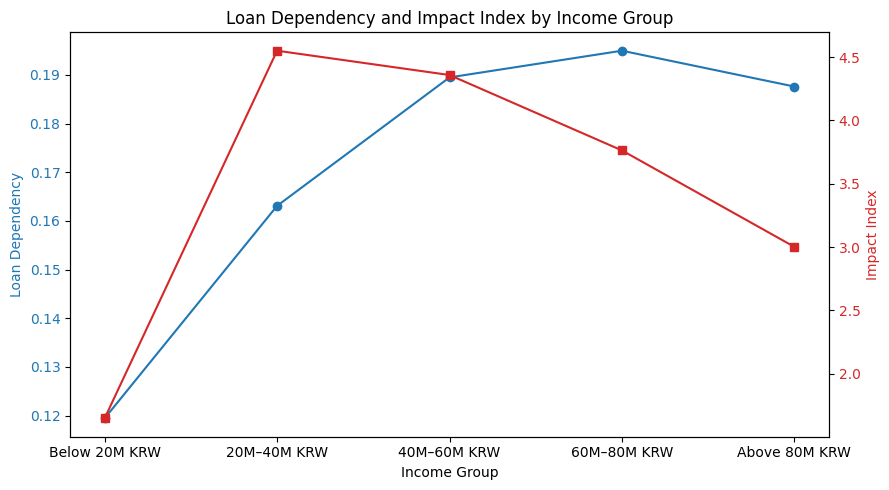

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype

eng_labels = {
    '2000만원 미만': 'Below 20M KRW',
    '2,000~4,000만원 미만': '20M–40M KRW',
    '4,000~6,000만원 미만': '40M–60M KRW',
    '6,000~8,000만원 미만': '60M–80M KRW',
    '8,000만원 이상': 'Above 80M KRW'
}

ordered_categories = [
    'Below 20M KRW',
    '20M–40M KRW',
    '40M–60M KRW',
    '60M–80M KRW',
    'Above 80M KRW'
]

df_plot = df_result.copy()
df_plot['Income Group'] = df_plot['소득구간'].map(eng_labels)

cat_dtype = CategoricalDtype(categories=ordered_categories, ordered=True)
df_plot['Income Group'] = df_plot['Income Group'].astype(cat_dtype)
df_plot = df_plot.sort_values('Income Group')

fig, ax1 = plt.subplots(figsize=(9, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Income Group')
ax1.set_ylabel('Loan Dependency', color=color1)
ax1.plot(df_plot['Income Group'], df_plot['대출의존도'],
         color=color1, marker='o', label='Loan Dependency')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Impact Index', color=color2)
ax2.plot(df_plot['Income Group'], df_plot['실질타격강도'],
         color=color2, marker='s', label='Impact Index')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Loan Dependency and Impact Index by Income Group')
plt.xticks(rotation=30)
fig.tight_layout()
plt.show()


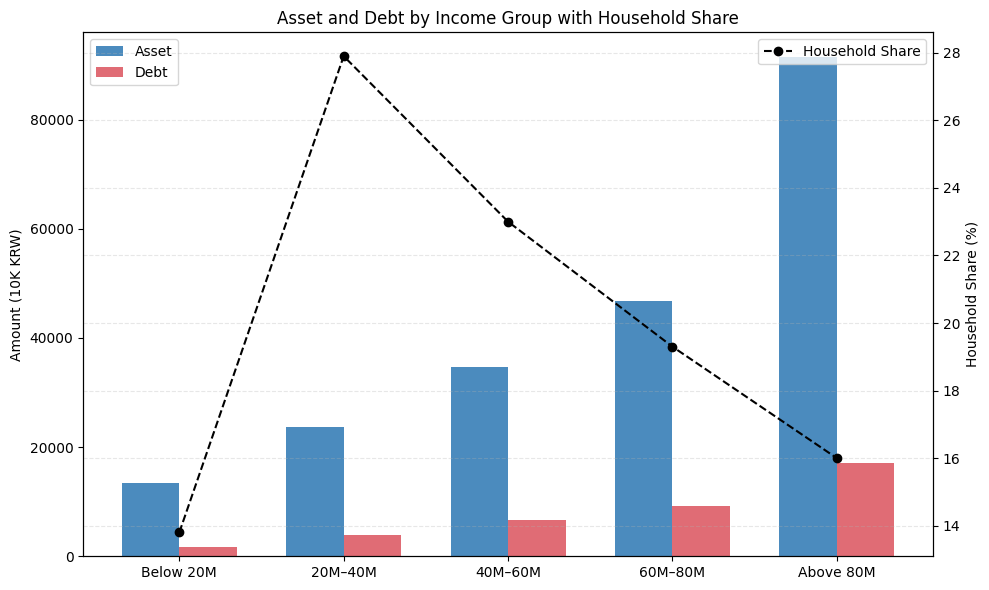

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype

eng_labels = {
    '2000만원 미만': 'Below 20M',
    '2,000~4,000만원 미만': '20M–40M',
    '4,000~6,000만원 미만': '40M–60M',
    '6,000~8,000만원 미만': '60M–80M',
    '8,000만원 이상': 'Above 80M'
}
ordered = ['Below 20M', '20M–40M', '40M–60M', '60M–80M', 'Above 80M']

df_plot = df_result.copy()
df_plot['Income Group'] = df_plot['소득구간'].map(eng_labels)
df_plot['Income Group'] = df_plot['Income Group'].astype(CategoricalDtype(categories=ordered, ordered=True))
df_plot = df_plot.sort_values('Income Group')


fig, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.35
x = range(len(df_plot))

ax1.bar([i - bar_width/2 for i in x], df_plot['자산'], width=bar_width, label='Asset', color='#4B8BBE')
ax1.bar([i + bar_width/2 for i in x], df_plot['부채'], width=bar_width, label='Debt', color='#E06C75')
ax1.set_ylabel('Amount (10K KRW)')
ax1.set_xticks(x)
ax1.set_xticklabels(df_plot['Income Group'])
ax1.legend(loc='upper left')
ax1.set_title('Asset and Debt by Income Group with Household Share')

ax2 = ax1.twinx()
ax2.plot(x, df_plot['가구비중'], color='black', marker='o', linestyle='--', label='Household Share')
ax2.set_ylabel('Household Share (%)')
ax2.legend(loc='upper right')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
